In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/newsdata/data/True.csv
/kaggle/input/newsdata/data/Fake.csv


In [2]:
# Import helpful libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# Load the data, and separate the target
f='../input/newsdata/data/Fake.csv'
t='../input/newsdata/data/True.csv'

fake = pd.read_csv(f)
true = pd.read_csv(t)

In [4]:
# Get the shape of fake and true data
fake.shape

(23481, 4)

In [5]:
true.shape

(21417, 4)

In [6]:
# Preview the first 5 rows of the fake data
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
# Preview the first 5 rows of the true data
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [9]:

# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [10]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [11]:
# preview first 5 rows of data
data.head()

,title,text,subject,date,target
0,"NFL policy on anthem kneeling unchanged, despi...",NEW YORK (Reuters) - National Football League ...,politicsNews,"October 17, 2017",true
1,Mnuchin tells Yale classmates: Trump does not ...,WASHINGTON (Reuters) - Urged by his Yale Unive...,politicsNews,"August 19, 2017",true
2,Trevor Noah Tears Ben Carson Apart For Attack...,It s hard to believe that Ben Carson is a brai...,News,"February 25, 2016",fake
3,Watch This CNN Host Need To Stop Himself From...,A lot of credit needs to be given to those who...,News,"February 26, 2016",fake
4,Protesters flood Barcelona demanding release o...,BARCELONA (Reuters) - Hundreds of thousands of...,worldnews,"November 11, 2017",true


In [12]:
# Removing the date and title column (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,NEW YORK (Reuters) - National Football League ...,politicsNews,true
1,WASHINGTON (Reuters) - Urged by his Yale Unive...,politicsNews,true
2,It s hard to believe that Ben Carson is a brai...,News,fake
3,A lot of credit needs to be given to those who...,News,fake
4,BARCELONA (Reuters) - Hundreds of thousands of...,worldnews,true


In [13]:
# Removing punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
data.head()

,text,subject,target
0,NEW YORK Reuters National Football League off...,politicsNews,true
1,WASHINGTON Reuters Urged by his Yale Universi...,politicsNews,true
2,It s hard to believe that Ben Carson is a brai...,News,fake
3,A lot of credit needs to be given to those who...,News,fake
4,BARCELONA Reuters Hundreds of thousands of Ca...,worldnews,true


In [15]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,new york reuters national football league off...,politicsNews,true
1,washington reuters urged by his yale universi...,politicsNews,true
2,it s hard to believe that ben carson is a brai...,News,fake
3,a lot of credit needs to be given to those who...,News,fake
4,barcelona reuters hundreds of thousands of ca...,worldnews,true


In [16]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
data.head()

,text,subject,target
0,new york reuters national football league offi...,politicsNews,true
1,washington reuters urged yale university class...,politicsNews,true
2,hard believe ben carson brain surgeon words co...,News,fake
3,lot credit needs given work media put presiden...,News,fake
4,barcelona reuters hundreds thousands catalan i...,worldnews,true


In [18]:
# DATA EXPLORATION

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


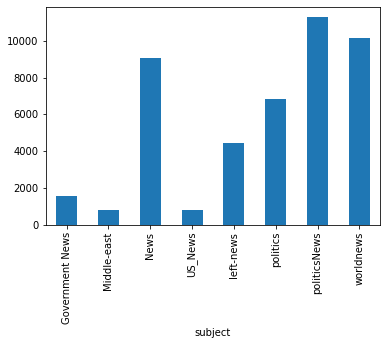

In [19]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


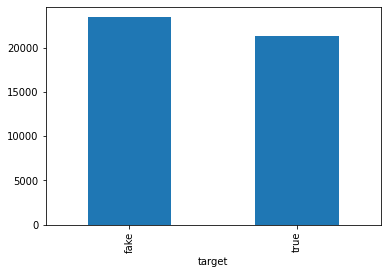

In [20]:

# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

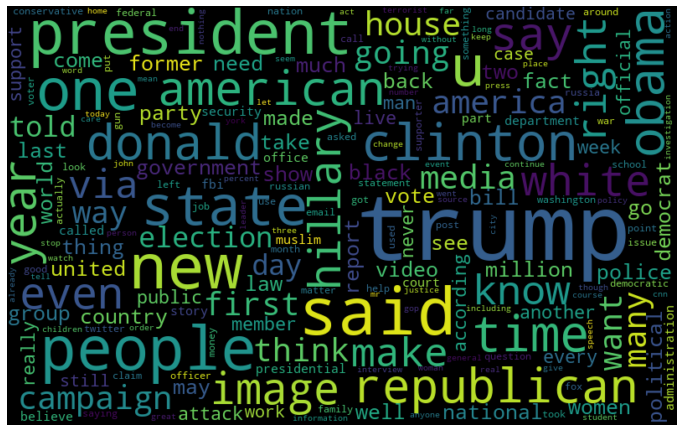

In [21]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

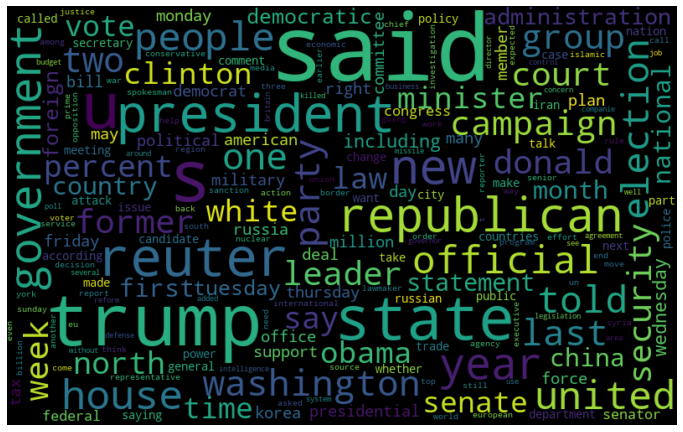

In [22]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

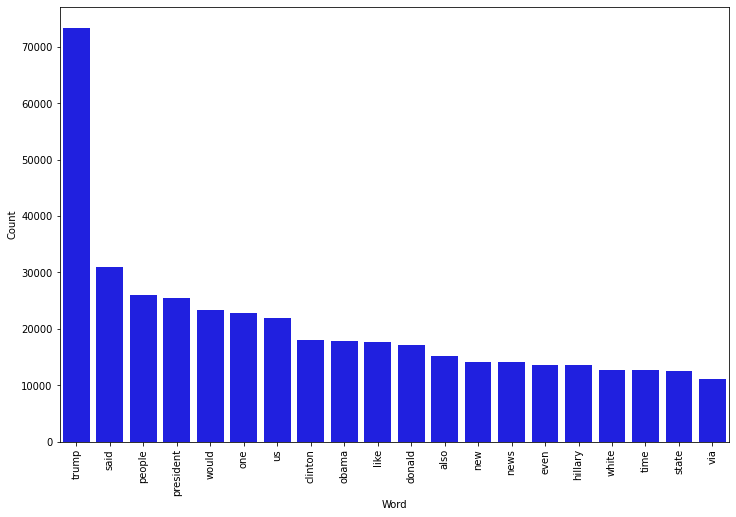

In [24]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

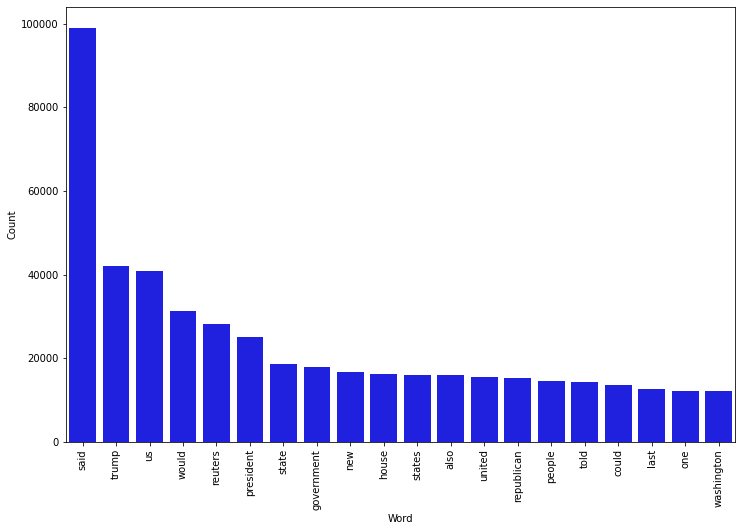

In [25]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [26]:
#MODELLING

In [27]:
# Function to plot the confusion matrix 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [29]:
#Tryung different modelling technique to get better prediction

In [30]:
#LOGISTIC REGRESSION

In [31]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model_1', LogisticRegression())])

# Fitting the model
model_1 = pipe.fit(X_train, y_train)

# Accuracy
prediction = model_1.predict(X_test)
print("Accuracy using Logistic Regression: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Accuracy using Logistic Regression: 98.91%


Confusion matrix, without normalization


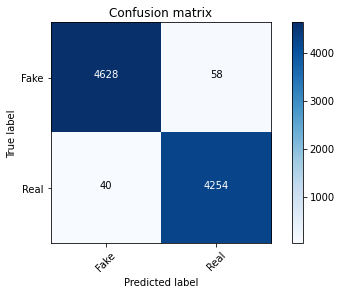

In [32]:
model1_cm=metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(model1_cm, classes=['Fake', 'Real'])

In [33]:
#RANDOM FOREST CLASSIFIER

In [34]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model_2', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

#fitting the model
model_2 = pipe.fit(X_train, y_train)

#prediction and accuracy
prediction = model_2.predict(X_test)
print("Accuracy using Random Forest Classifier: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Accuracy using Random Forest Classifier: 98.69%


Confusion matrix, without normalization


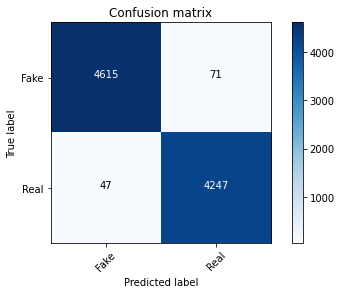

In [35]:
model2_cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(model2_cm, classes=['Fake', 'Real'])

In [36]:
#DECISION TREE CLASSIFIER

In [37]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model_3', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model_3 = pipe.fit(X_train, y_train)

# Accuracy
prediction = model_3.predict(X_test)
print("Accuracy using Decision Tree Classifier: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


Accuracy using Decision Tree Classifier: 99.65%


Confusion matrix, without normalization


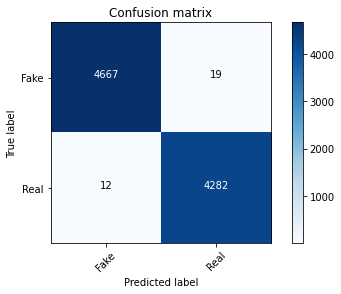

In [38]:
model3_cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(model3_cm, classes=['Fake', 'Real'])

In [39]:
# Run the code to save predictions in the format used for competition scoring
output = pd.DataFrame(model3_cm)
output.to_csv('submission.csv', index=False)